In [13]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
c
from pathlib import Path

from statsmodels.tsa.api import VAR

import var
import geoii

def compute_all_information(sigma_e_, sigma_e, sigma_x):
    sigma_e_star_11 = sigma_e[0, 0] - sigma_e[1, 0] * sigma_e[0, 1] / sigma_e[1, 1]
    sigma_e_star_22 = sigma_e[1, 1] - sigma_e[1, 0] * sigma_e[0, 1] / sigma_e[0, 0]
    sigma_e_11 = sigma_e[0, 0]
    sigma_e_22 = sigma_e[1, 1]
    phi_G = 1 / 2 * np.log(det(sigma_e_) / det(sigma_e))
    MI = 1 / 2 * np.log(det(sigma_x) / det(sigma_e))
    TE12 = -1 / 2 * np.log((sigma_e_star_11) / (sigma_e_11))
    TE21 = -1 / 2 * np.log((sigma_e_star_22) / (sigma_e_22))
    return {"phi_G": phi_G, "MI": MI, "TE(1->2)": TE12, "TE(2->1)": TE21}

def compute_all_info_from_param(A_true, Sigma_true, N=1000, data_filename=None):
    mask = np.array([[1, 0], [0, 1]])
    initiali_state = np.random.multivariate_normal(
        [0, 0], [[0.1, 0], [0, 0.1]], size=1
    )[0]
    stateList = var.generate(initiali_state, A_true, Sigma_true, N=N)
    if data_filename:
        plt.clf()
        plt.plot(stateList)
        plt.savefig(data_filename)
    x = np.array(stateList[:-1])
    ar = VAR(stateList).fit(trend="n", maxlags=1)
    a = ar.params
    sigma_e = ar.sigma_u
    SigmaX = np.cov(x.T)
    result = geoii.fit_q(a, sigma_e, SigmaX, mask)
    result["A"] = a
    result["SigmaE"] = sigma_e
    result["SigmaX"] = SigmaX
    return result

def experiment_geoii(datadir):
    all_result_d1 = []
    c_range = np.arange(0.0, 0.4, 0.01)
    d = 0.03
    for ci, c in enumerate(c_range):
        A_true = np.array([[0.9, d], [d, 0.9]])
        Sigma_true = np.array([[0.2, c], [c, 0.2]])
        filename = "data_c_{:.2}_d_{:.3}.png".format(c, d)
        result = compute_all_info_from_param(A_true, Sigma_true, data_filename=str(datadir/filename))
        info = compute_all_information(
            result["SigmaE_min"], result["SigmaE"], result["SigmaX"]
        )
        print("c=", c, "d=", d, info)
        all_result_d1.append((info, result))
    x = []
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    c_range = np.arange(0.0, 0.4, 0.01)
    for i, el in enumerate(all_result_d1):
        info, result = el
        y1.append(info["phi_G"])
        y2.append(info["MI"])
        y3.append(info["TE(1->2)"])
        y4.append(info["TE(2->1)"])
        y5.append(info["TE(1->2)"] + info["TE(2->1)"])
        x.append(c_range[i])
    plt.plot(x, y1, label="phi_G")
    plt.plot(x, y2, label="MI")
    plt.plot(x,y3,label="TE(1->2)")
    plt.plot(x,y4,label="TE(2->1)")
    plt.plot(x,y5,label="TE(sum)")
    plt.legend()


c= 0.0 d= 0.03 {'phi_G': 0.006169658162241261, 'MI': 1.5771912704597735, 'TE(1->2)': 0.0008919160619813223, 'TE(2->1)': 0.0008919160619812667}
c= 0.01 d= 0.03 {'phi_G': 0.009013689607897448, 'MI': 1.7358442929434146, 'TE(1->2)': 0.007464321775008258, 'TE(2->1)': 0.007464321775008258}
c= 0.02 d= 0.03 {'phi_G': 0.0036676032644616416, 'MI': 1.9453577000169924, 'TE(1->2)': 0.006175318549429777, 'TE(2->1)': 0.006175318549429777}
c= 0.03 d= 0.03 {'phi_G': 0.0007485404698019847, 'MI': 1.566636110300353, 'TE(1->2)': 0.007976464737121807, 'TE(2->1)': 0.007976464737121807}
c= 0.04 d= 0.03 {'phi_G': 0.009885884864057193, 'MI': 1.6590370947771584, 'TE(1->2)': 0.02242582640779747, 'TE(2->1)': 0.022425826407797413}
c= 0.05 d= 0.03 {'phi_G': 0.007482427443479075, 'MI': 1.746808795789624, 'TE(1->2)': 0.03952508477624314, 'TE(2->1)': 0.039525084776243204}
c= 0.06 d= 0.03 {'phi_G': 0.008830651249908063, 'MI': 1.701510399719415, 'TE(1->2)': 0.060562820013481455, 'TE(2->1)': 0.060562820013481455}
c= 0.07 

KeyboardInterrupt: 

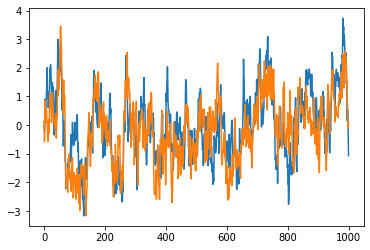

In [14]:
now = datetime.datetime.now()
datadir = Path("../data") / "exp_geoii_div" / now.strftime('%Y%m%d-%H%M%S')
datadir.mkdir(parents=True, exist_ok=True)

experiment_geoii(datadir)